# Анализ датасета о причинах депрессии и самоубийств

## Загрузка данных, анализ и описание данных

Источник данных - https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch
Цель проекта - анализ датасета о причинах депрессии и самоубийств. В описании указано, что этот набор данных представляет собой коллекцию постов из разделов "SuicideWatch" и "depression" платформы Reddit. Посты собираются с помощью API Pushshift. Все посты, которые были сделаны в "SuicideWatch" с 16 декабря 2008 г. (создание) по 2 января 2021 г., были собраны, в то время как посты "depression" были собраны с 1 января 2009 г. по 2 января 2021 г. Все посты, собранные с SuicideWatch, помечены как самоубийство, в то время как посты, собранные с раздела "depression", помечены как депрессия. Несуицидные посты собираются с r/teenagers.

In [1]:
#загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# чтение файла с данными и сохранение в suicide
df = pd.read_csv('/content/Suicide_Detection.csv')

In [4]:
def data_review (data):
    print('ТИПЫ ДАННЫХ\n')
    display(data.info())
    print('ПРОПУСКИ\n')

    for element in data.columns:
        if data[element].isna().sum() > 0:
            print(element, ' - ', data[element].isna().sum(), 'пропусков\n')
            count = +1
        else: print(element, ' - пропусков НЕТ\n')
    print('\nПРОЦЕНТ ПРОПУСКОВ ИЗ ВСЕГО ДАТАСЕТА')
    display(data.isna().mean().sort_values(ascending=False)*100)

data_review (df)

ТИПЫ ДАННЫХ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


None

ПРОПУСКИ

Unnamed: 0  - пропусков НЕТ

text  - пропусков НЕТ

class  - пропусков НЕТ


ПРОЦЕНТ ПРОПУСКОВ ИЗ ВСЕГО ДАТАСЕТА


,0
Unnamed: 0,0.0
text,0.0
class,0.0


In [5]:
# изменяем допустимое количество символов вывода в столбце до 500
#pd.options.display.max_colwidth = 500
#print(df.head(5))

In [6]:
# проверим уникальные значения в столбце suicide/non-suicide
class_un=df['class'].unique()
class_un

array(['suicide', 'non-suicide'], dtype=object)

In [7]:
# убираем колонку unnamed
df=df.drop(columns='Unnamed: 0',axis=1)
df.head()

,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,Am I weird I don't get affected by compliments...,non-suicide
2,Finally 2020 is almost over... So I can never ...,non-suicide
3,i need helpjust help me im crying so hard,suicide
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


**ВЫВОД** В датасете мы имеем 3 поля: unnamed - индекс сообщения, text - текст сообщения и class - суицид/несуицид , всего 232074 записей, по столбцу text - 0 пропусков, по столбцу class - 0 пропусков. Unnamed можно убрать.

## Анализ данных, обработка, визуализация

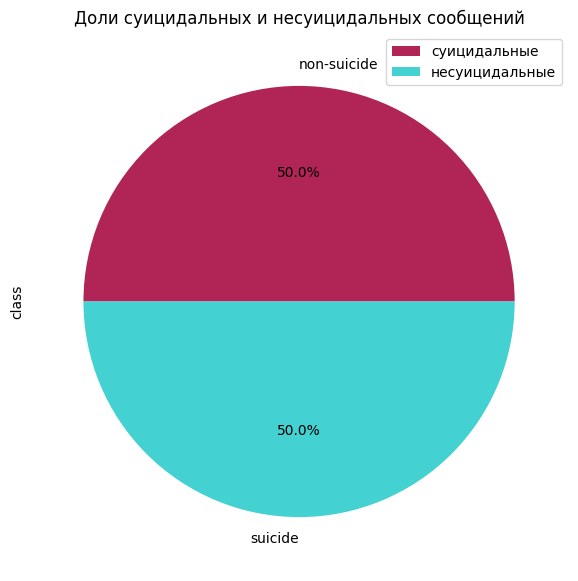

In [8]:
# группируем по признакам class, строим круговую диаграмму (к заданию 5)
sui_perc = df.groupby('class').agg({'class': 'count'})
sui_perc.plot(kind='pie', y='class', autopct='%1.1f%%', figsize=(7,7), colors=["#b02556", "#43d1d1"])
plt.title('Доли суицидальных и несуицидальных сообщений')
plt.legend(['суицидальные', 'несуицидальные'])
plt.show()

**ВЫВОД** В данном датафрейме приведены текстовые сообщения для одинакового количества суицидных и несуицидных случаев. Круговая диаграмма по этому признаку не несет каких либо полезных данных, изучим свойства текста по количеству слов, символов, содержанию слов, частоте их использования

In [9]:
# Создание нового признака с помощью анонимной функции (количество слов в тексте) - задание 6
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))

# Создание нового признака с помощью функции (количество символов в тексте) - задание 6
def char_count(text):
    return len(str(text))

df["char_count"] = df["text"].apply(char_count)
print(df.head(5))

                                                text        class  word_count  \
0  Ex Wife Threatening SuicideRecently I left my ...      suicide         143   
1  Am I weird I don't get affected by compliments...  non-suicide          27   
2  Finally 2020 is almost over... So I can never ...  non-suicide          26   
3          i need helpjust help me im crying so hard      suicide           9   
4  I’m so lostHello, my name is Adam (16) and I’v...      suicide         438   

   char_count  
0         715  
1         138  
2         129  
3          41  
4        2426  


In [10]:
# Функция для подсчета уникальных слов
def count_words(text_series):
    words = []
    for text in text_series.dropna():  # Убираем NaN значения
        words.extend(re.findall(r'\b\w+\b', text.lower()))  # Разбиваем на слова и приводим к нижнему регистру
    return Counter(words)

In [11]:
# Подсчет частоты слов во всем датасете
word_counts_all = count_words(df["text"])

# Разделение на два датафрейма
df_suicide = df[df["class"] == "suicide"]
df_non_suicide = df[df["class"] == "non-suicide"]

# Подсчет частоты слов отдельно для каждого класса
word_counts_suicide = count_words(df_suicide["text"])
word_counts_non_suicide = count_words(df_non_suicide["text"])

In [12]:
# Создание частотной таблицы количества слов
word_count_freq = df['word_count'].value_counts().reset_index()
word_count_freq.columns = ['word_count', 'frequency']
print("Частотная таблица количества слов в тексте:")
print(word_count_freq)

Частотная таблица количества слов в тексте:
      word_count  frequency
0             18       3492
1             17       3451
2             19       3399
3             16       3372
4             20       3285
...          ...        ...
1986        3628          1
1987        1712          1
1988        1461          1
1989        2041          1
1990        1627          1

[1991 rows x 2 columns]


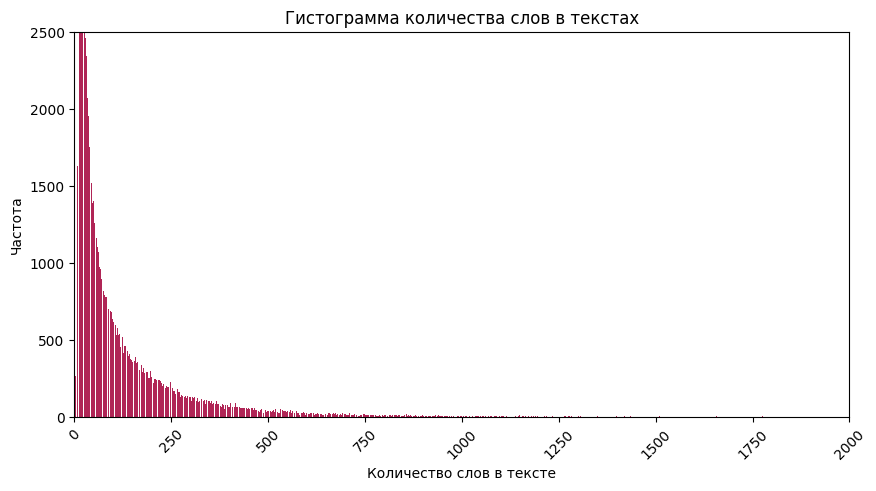

In [13]:
# Построение гистограммы
plt.figure(figsize=(10, 5))
plt.bar(word_count_freq['word_count'], word_count_freq['frequency'], color='#b02556')
plt.xlabel("Количество слов в тексте")
plt.ylabel("Частота")
plt.xlim(0,2000)
plt.ylim(0,2500)
plt.title("Гистограмма количества слов в текстах")
plt.xticks(rotation=45)
plt.show()

<ipython-input-14-51b4b8c48d71>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="word_count", data=df, palette=["#b02556", "#43d1d1"])


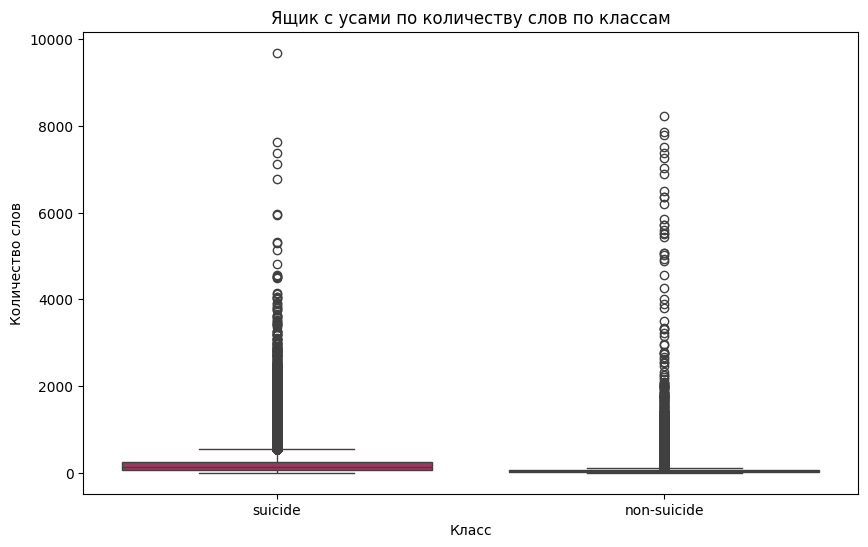

In [14]:
# Построение ящиков с усами для word_count по классам (задание 2)
plt.figure(figsize=(10, 6))
sns.boxplot(x="class", y="word_count", data=df, palette=["#b02556", "#43d1d1"])
plt.title("Ящик с усами по количеству слов по классам")
plt.xlabel("Класс")
plt.ylabel("Количество слов")
plt.show()

<ipython-input-15-a5dcebb6277a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="class", y="word_count", data=df, palette=["#b02556", "#43d1d1"])


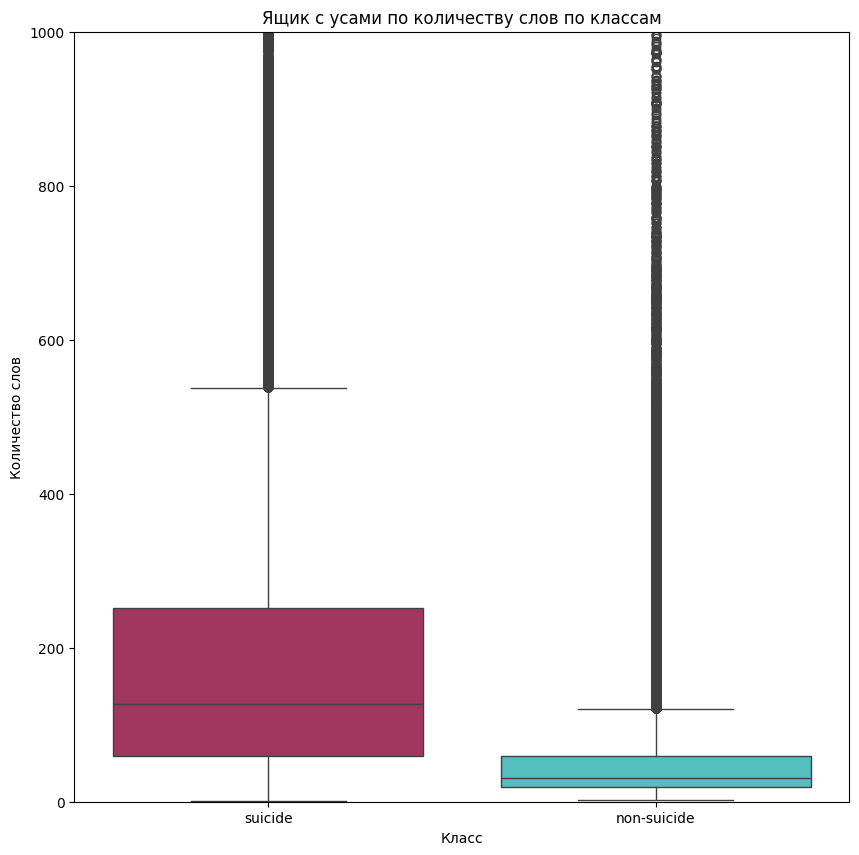

In [15]:
#Перерисуем, изменив границы
plt.figure(figsize=(10, 10))
sns.boxplot(x="class", y="word_count", data=df, palette=["#b02556", "#43d1d1"])
plt.title("Ящик с усами по количеству слов по классам")
plt.xlabel("Класс")
plt.ylabel("Количество слов")
plt.ylim(0, 1000) # изменим лимиты отображения
plt.show()

**ВЫВОД:** Всего коротких постов ожидаемо гораздо больше, но можно уверенно утверждать, что суицидные тексты содержат больше слов

In [16]:
# Группировки (задание 7)
grouped_1 = df.groupby("class")["word_count"].mean()
grouped_2 = df.groupby("class")[["char_count", "word_count"]].mean()
grouped_3 = df.groupby("class")["char_count"].agg(["mean", "median"])
grouped_4 = df.groupby("class")[["char_count", "word_count"]].agg(["mean", "median"])
print('Среднее количество слов', grouped_1)
print('Среднее количество слов и символов', grouped_2)
print('Медианное количество символов', grouped_3)
print('Медианное количество символов и слов', grouped_4)

Среднее количество слов class
non-suicide     61.188302
suicide        202.662168
Name: word_count, dtype: float64
Среднее количество слов и символов               char_count  word_count
class                               
non-suicide   329.218844   61.188302
suicide      1050.060627  202.662168
Медианное количество символов                     mean  median
class                           
non-suicide   329.218844   165.0
suicide      1050.060627   653.0
Медианное количество символов и слов               char_count         word_count       
                    mean median        mean median
class                                             
non-suicide   329.218844  165.0   61.188302   31.0
suicide      1050.060627  653.0  202.662168  127.0


<function matplotlib.pyplot.show(close=None, block=None)>

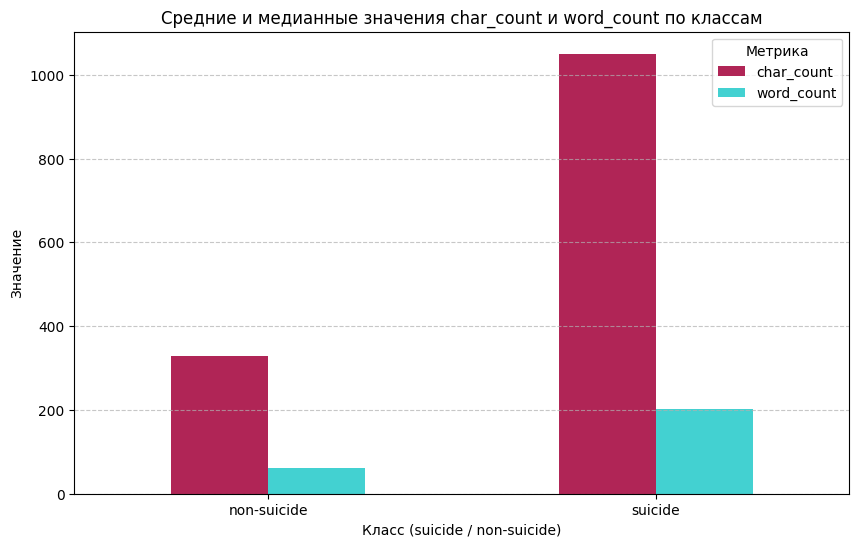

In [17]:
# Построение столбчатой диаграммы
grouped_2.plot(kind="bar", figsize=(10, 6), color=["#b02556", "#43d1d1"])
plt.title("Средние и медианные значения char_count и word_count по классам")
plt.xlabel("Класс (suicide / non-suicide)")
plt.ylabel("Значение")
plt.legend(title="Метрика", loc="upper right")
plt.xticks(rotation=0)  # Поворот подписей классов для лучшей читаемости
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show

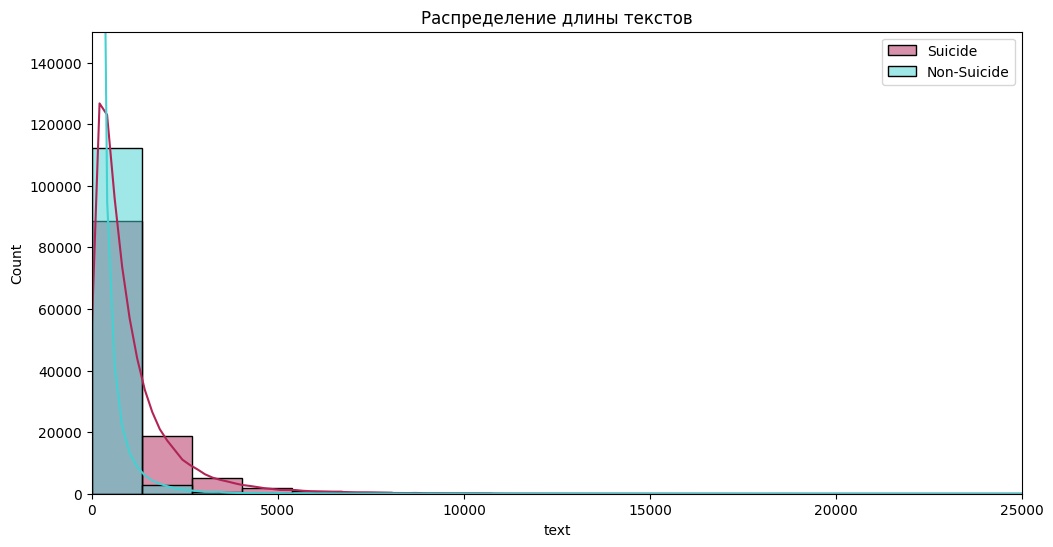

In [18]:
# построим гистограмму распределения длины текстов (задание 2 этап 2)
plt.figure(figsize=(12, 6))
sns.histplot(df[df["class"] == "suicide"]["text"].str.len(), bins=30, kde=True, color='#b02556', label='Suicide')
sns.histplot(df[df["class"] == "non-suicide"]["text"].str.len(), bins=30, kde=True, color='#43d1d1', label='Non-Suicide')
plt.legend()
plt.title("Распределение длины текстов")
plt.xlim(0, 25000) # изменим лимиты отображения
plt.ylim(0, 150000)
plt.show()

In [19]:

# Преобразование в DataFrame для удобства
all_word_freq_df = pd.DataFrame(word_counts_all.items(), columns=["Word", "Frequency"]).sort_values(by="Frequency", ascending=False).reset_index(drop=True)
suicide_word_freq_df = pd.DataFrame(word_counts_suicide.items(), columns=["Word", "Frequency"]).sort_values(by="Frequency", ascending=False).reset_index(drop=True)
non_suicide_word_freq_df = pd.DataFrame(word_counts_non_suicide.items(), columns=["Word", "Frequency"]).sort_values(by="Frequency", ascending=False).reset_index(drop=True)
print('All', all_word_freq_df.head())
print('suicide', suicide_word_freq_df.head())
print('non-suicide', non_suicide_word_freq_df.head())

All   Word  Frequency
0    i    2219227
1   to    1037640
2  and     898153
3  the     684073
4    a     625527
suicide   Word  Frequency
0    i    1854840
1   to     850136
2  and     707852
3  the     515084
4   my     507911
non-suicide   Word  Frequency
0    i     364387
1  and     190301
2   to     187504
3  the     168989
4    a     160064


**ВЫВОД.** Наиболее часто используемые слова в текстах - местоимения (чаще всего "Я"), предлоги и артикли. Эти слова очевидно самые используемые в любых речевых конструкциях

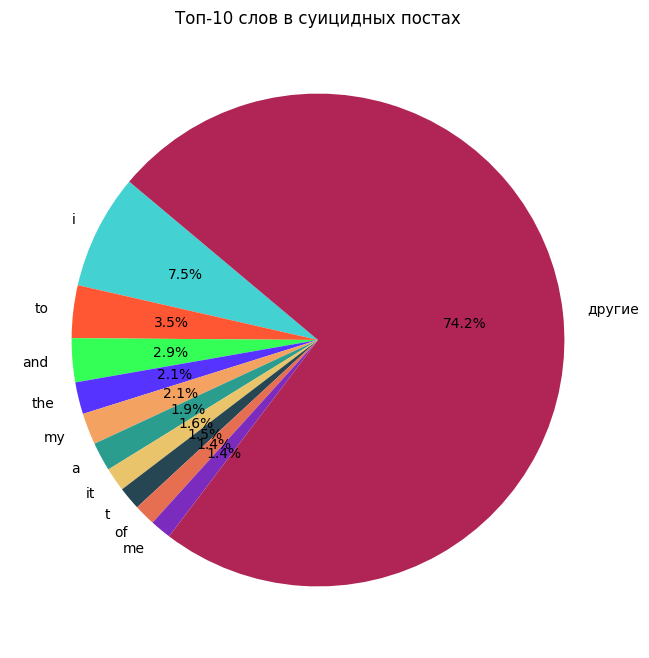

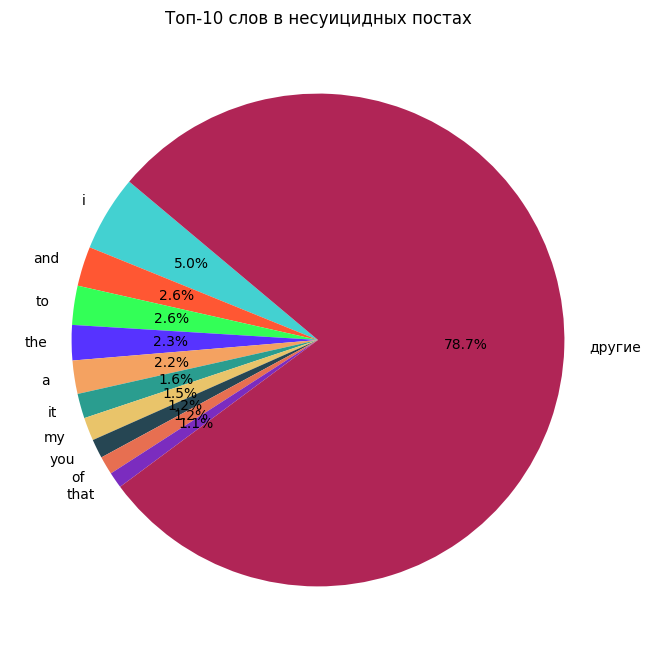

In [26]:
# Функция для построения круговой диаграммы
def plot_pie_chart(word_counts, title):
    top_words = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:10])
    other_count = sum(word_counts.values()) - sum(top_words.values())
    top_words["другие"] = other_count
    colors = ["#43d1d1", "#ff5733", "#33ff57", "#5733ff",
          "#f4a261", "#2a9d8f", "#e9c46a", "#264653", "#e76f51", "#7b2cbf", "#b02556"]
    sns.color_palette("flare", as_cmap=True)
    plt.figure(figsize=(8, 8))
    plt.pie(top_words.values(), labels=top_words.keys(), autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(title)
    plt.show()

# Построение круговых диаграмм для топ-10 слов
plot_pie_chart(word_counts_suicide, "Топ-10 слов в суицидных постах")
plot_pie_chart(word_counts_non_suicide, "Топ-10 слов в несуицидных постах")

In [27]:
# Фильтрация по одному условию
filtered_suicide = df_suicide[df_suicide["text"].str.len() > 100]  # Сообщения длиннее 100 символов
filtered_non_suicide = df_non_suicide[df_non_suicide["text"].str.len() > 100]
print(filtered_suicide)
print(filtered_non_suicide)

                                                     text    class  \
0       Ex Wife Threatening SuicideRecently I left my ...  suicide   
4       I’m so lostHello, my name is Adam (16) and I’v...  suicide   
5       Honetly idkI dont know what im even doing here...  suicide   
6       [Trigger warning] Excuse for self inflicted bu...  suicide   
9       My life is over at 20 years oldHello all. I am...  suicide   
...                                                   ...      ...   
232061  I’ve fucking had enough.None of this depressio...  suicide   
232062  paralyzing anxiety &amp; depression are pushin...  suicide   
232066  My mom tried to kill herself today. I feel los...  suicide   
232067  I’m a fucking scummy person and I can’t change...  suicide   
232072  The usual stuff you find hereI'm not posting t...  suicide   

        word_count  char_count  
0              143         715  
4              438        2426  
5              291        1479  
6              243        1

In [28]:
# Фильтрация по нескольким условиям
multi_filtered_suicide = df_suicide[(df_suicide["text"].str.len() > 100) & (df_suicide["text"].str.contains("help", case=False))]
multi_filtered_non_suicide = df_non_suicide[(df_non_suicide["text"].str.len() > 100) & (df_non_suicide["text"].str.contains("happy", case=False))]

In [29]:
# Сортировка по длине текста
sorted_suicide_asc = df_suicide.sort_values(by="text", key=lambda x: x.str.len(), ascending=True)
sorted_suicide_desc = df_suicide.sort_values(by="text", key=lambda x: x.str.len(), ascending=False)

sorted_non_suicide_asc = df_non_suicide.sort_values(by="text", key=lambda x: x.str.len(), ascending=True)
sorted_non_suicide_desc = df_non_suicide.sort_values(by="text", key=lambda x: x.str.len(), ascending=False)


## Описательная статистика, корреляция, построение и оценка модели

In [30]:
# Описательная статистика
numeric_desc = df["word_count"].describe()
categorical_desc = df["class"].mode(), df["class"].nunique()
print(numeric_desc)
print(categorical_desc)

count    232074.000000
mean        131.925235
std         217.476787
min           1.000000
25%          26.000000
50%          60.000000
75%         155.000000
max        9684.000000
Name: word_count, dtype: float64
(0    non-suicide
1        suicide
Name: class, dtype: object, 2)


In [31]:
# Удаление выбросов (метод 1.5 IQR и N*std)
Q1 = df["word_count"].quantile(0.25)
Q3 = df["word_count"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_no_outliers = df[(df["word_count"] >= lower_bound) & (df["word_count"] <= upper_bound)]
print(f'Q1={Q1}, Q3={Q3}, IQR={IQR}, lower_bound={lower_bound}, upper_bound={upper_bound}')

Q1=26.0, Q3=155.0, IQR=129.0, lower_bound=-167.5, upper_bound=348.5


In [32]:
print(df_no_outliers)

                                                     text        class  \
0       Ex Wife Threatening SuicideRecently I left my ...      suicide   
1       Am I weird I don't get affected by compliments...  non-suicide   
2       Finally 2020 is almost over... So I can never ...  non-suicide   
3               i need helpjust help me im crying so hard      suicide   
5       Honetly idkI dont know what im even doing here...      suicide   
...                                                   ...          ...   
232068  I did something today I went sledding with my ...  non-suicide   
232069  If you don't like rock then your not going to ...  non-suicide   
232070  You how you can tell i have so many friends an...  non-suicide   
232071  pee probably tastes like salty tea😏💦‼️ can som...  non-suicide   
232073  I still haven't beaten the first boss in Hollo...  non-suicide   

        word_count  char_count  
0              143         715  
1               27         138  
2           

In [33]:
std_limit = 3
df_no_outliers = df_no_outliers[(np.abs(stats.zscore(df_no_outliers["char_count"])) < std_limit)]

# Обнаружение пропущенных значений
missing_values = df.isnull().sum()
df.fillna(df.median(numeric_only=True), inplace=True)

In [34]:
# Корреляционный анализ
df_no_outliers_corr=df_no_outliers[['char_count','word_count']]
print(df_no_outliers_corr)

        char_count  word_count
0              715         143
1              138          27
2              129          26
3               41           9
5             1479         291
...            ...         ...
232068         179          38
232069         152          19
232070         158          31
232071          87          14
232073         167          33

[211635 rows x 2 columns]


In [35]:
corr_matrix = df_no_outliers_corr.corr()
print(corr_matrix)

            char_count  word_count
char_count    1.000000    0.991911
word_count    0.991911    1.000000


In [36]:
strongest_corr = corr_matrix.unstack().sort_values(ascending=False).drop_duplicates()
highest_corr_pair = strongest_corr.index[1]
print(strongest_corr)
print(highest_corr_pair)

char_count  char_count    1.000000
            word_count    0.991911
dtype: float64
('char_count', 'word_count')


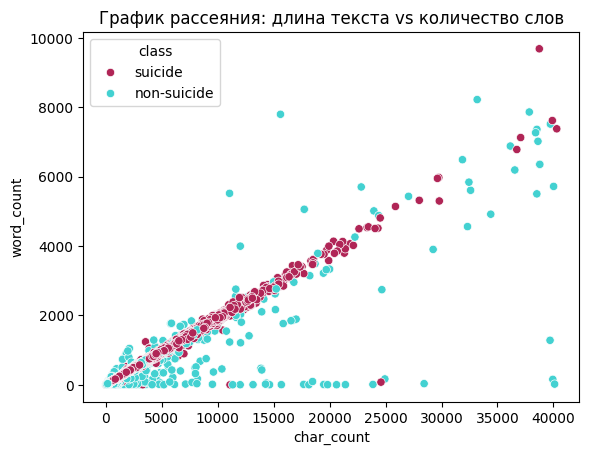

In [40]:
# График рассеяния
sns.scatterplot(x=df["char_count"], y=df["word_count"], hue=df["class"], palette={"suicide": "#b02556", "non-suicide": "#43d1d1"})
plt.title("График рассеяния: длина текста vs количество слов")
plt.show()

**ВЫВОД** в суицидных текстах корреляция между количеством символов и количеством слов более сильная, вероятно в несуицидальных чаще используются нетипичные слишком длинные или короткие слова, смайлики, эмодзи, "неслова" из рандомных символов или пропущены пробелы

In [41]:
# Линейная регрессия
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [42]:
X = df_no_outliers[["char_count"]]
y = df_no_outliers["word_count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

model.coef_, model.intercept_, mae, rmse

(array([0.19238609]),
 -0.058340298519695466,
 4.803567558494255,
 10.273349382894638)

In [43]:
# Метрики качества
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}, R2 Score: {r2}")

MSE: 105.54170754302164, R2 Score: 0.9828757763564965


**ВЫВОД:** Модель очень хорошо предсказывает количество слов на основе длины текста. Высокий R² говорит о почти идеальной линейной зависимости.MSE невелик, что тоже подтверждает хорошее качество модели